In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time
import matplotlib.pyplot as plt
# from sklearn_evaluation import plot

print("Imports complete")

: 

In [ ]:
# Load the data from the text file, ignoring the first line

filename="./data/MiniBooNE_PID.txt"
data=pd.read_csv(filename,delim_whitespace=True,skiprows=1,header=None)
print(data.head(1))
X=data

In [ ]:
""" Create target vector for each row of the dataset. 
The first value in the first row contains the number of signal events, the second the number of background events. 
The target vector should contain 1 for signal events and 0 for background events."""

# Get number of signal and background events
signal, background = open(filename).readline().split()

y = np.concatenate((np.ones(int(signal)), np.zeros(int(background))))
print(y.shape)

In [ ]:
# Standardize the input data
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

In [ ]:
""" save the scaled matrix and the target vector as npy files """
np.save('X.npy', X_scaled)
np.save('y.npy', y)

In [3]:
X=np.load('X.npy') # load the scaled matrix
y=np.load('y.npy')

In [4]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Create a vanilla neural network classifier and train it on the training data
nn_clf = MLPClassifier(random_state=42)

# Define the hyperparameter space to search over for the vanilla neural network classifier
nn_param_grid = {
    'hidden_layer_sizes': [(40,40)],
    'activation': ["logistic", "tanh", "identity"],
    # 'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [500],
    'random_state': [42]
}

# Set up the grid search using 5-fold cross-validation
nn_grid_search = GridSearchCV(nn_clf, nn_param_grid, cv=5, scoring='accuracy',verbose=10)
# nn_grid_search = RandomizedSearchCV(nn_clf, nn_param_grid, cv=5, scoring='accuracy', n_iter=2)

# Perform the grid search on the training set
nn_start_time = time.time()
nn_grid_search.fit(X_train, y_train)
nn_end_time = time.time()
print('Time required to grid search Vanilla Neural Network classifier:', nn_end_time - nn_start_time)

print('Vanilla Neural Network best hyperparameters:', nn_grid_search.best_params_)
print('Vanilla Neural Network best cross-validation accuracy:', nn_grid_search.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START activation=logistic, hidden_layer_sizes=(40, 40), max_iter=500, random_state=42
[CV 1/5; 1/3] END activation=logistic, hidden_layer_sizes=(40, 40), max_iter=500, random_state=42;, score=0.934 total time= 2.5min
[CV 2/5; 1/3] START activation=logistic, hidden_layer_sizes=(40, 40), max_iter=500, random_state=42


In [ ]:
# Re-train the classifier using the best hyperparameters on the full training set
nn_clf = nn_grid_search.best_estimator_

nn_start_time = time.time()
nn_clf.fit(X_train, y_train)
nn_end_time = time.time()

# Evaluate the classifier on the test set
nn_test_accuracy = nn_grid_search.score(X_test, y_test)
print('Time required to train Vanilla Neural Network classifier:', nn_end_time - nn_start_time)
print('Vanilla Neural Network test accuracy:', nn_test_accuracy)

In [ ]:
# Get the results of the grid search
nn_results = nn_grid_search.cv_results_

nn_mean_scores = nn_results['mean_test_score']
nn_mean_times = nn_results['mean_fit_time']
nn_params = nn_results['param_hidden_layer_sizes']

# Loop through each combination of hyperparameters
for mean_score, mean_time, param in zip(nn_mean_scores, nn_mean_times, nn_params):
    print("HiddenLayerSize: %r | %.2fs | test-score: %f" % (param, mean_time, mean_score))

In [ ]:
""" plot the results of the grid search against the hyperparameter values """
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot([1,2,3,4], nn_mean_scores, 'o:', label="Mean Score", linestyle=':')
ax2.plot([1,2,3,4], nn_mean_times, 'o:', color='orange', label="Mean Fit Time")
ax1.set_xlabel('Number of hidden layers of size 40')
ax1.set_ylabel('Score', color='blue')
ax2.set_ylabel('Fit time [s]', color='orange')

plt.show()

In [ ]:
from thundersvm import SVC

In [21]:
# Create a SVM classifier and train it on the training data
svm_clf = SVC(kernel="rbf",random_state=42)

svm_param_grid = {
    'kernel': ['linear','poly', 'sigmoid'],
    'C': [10],
    'gamma': ['auto'],
    'random_state': [42],
}

svm_grid_search = GridSearchCV(svm_clf, svm_param_grid, cv=5, scoring='accuracy', verbose=10)

svm_start_time = time.time()
svm_grid_search.fit(X_train, y_train)
svm_end_time = time.time()

print('SVM best hyperparameters:', svm_grid_search.best_params_)
print('SVM best cross-validation accuracy:', svm_grid_search.best_score_)
print('Time required to perform GridSearch on SVM classifier:', svm_end_time - svm_start_time, 'seconds')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START C=10, gamma=auto, kernel=linear, random_state=42............


In [ ]:
svm_clf = svm_grid_search.best_estimator_

svm_clf.fit(X_train, y_train)

svm_test_accuracy = svm_grid_search.score(X_test, y_test)
print('Time required to train SVM classifier:', svm_end_time - svm_start_time)
print('SVM test accuracy:', svm_test_accuracy)

In [ ]:
# Get the results of the grid search
svm_results = svm_grid_search.cv_results_

svm_mean_scores = svm_results['mean_test_score']
svm_mean_score_times = svm_results['mean_score_time']
svm_mean_fit_times = svm_results['mean_fit_time']
svm_param_C = svm_results['param_C']

for mean_score, mean_score_time, mean_fit_time, param in zip(svm_mean_scores, svm_mean_score_times, svm_mean_fit_times, svm_param_C):
    print("C: %r | %.2fs | test-score: %f" % (param, mean_fit_time, mean_score))

In [ ]:
""" plot the results of the grid search against the hyperparameter values """
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(svm_param_C, svm_mean_scores,'o:', color='blue', label="Mean Score")
ax2.plot(svm_param_C, svm_mean_fit_times,'o:', color='orange', label="Mean Fit Time")
ax1.set_xlabel('Regularization parameter')
ax1.set_ylabel('Score', color='blue')
ax2.set_ylabel('Fit time', color='orange')

plt.show()

In [16]:
# Create a random forest classifier and train it on the training data
rf_clf = RandomForestClassifier(random_state=42)

rf_param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [10,15,20],
    "min_samples_split": [2, 5, 10],
}

rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=5, scoring='accuracy', verbose=10)

rf_start_time = time.time()
rf_grid_search.fit(X_train, y_train)
rf_end_time = time.time()

print('RF best hyperparameters:', rf_grid_search.best_params_)
print('RF best cross-validation accuracy:', rf_grid_search.best_score_)
print('Time required to grid search for RF classifier:', rf_end_time - rf_start_time)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START max_depth=20, min_samples_split=2, n_estimators=50..........
[CV 1/5; 1/3] END max_depth=20, min_samples_split=2, n_estimators=50;, score=0.933 total time=  38.2s
[CV 2/5; 1/3] START max_depth=20, min_samples_split=2, n_estimators=50..........
[CV 2/5; 1/3] END max_depth=20, min_samples_split=2, n_estimators=50;, score=0.934 total time=  38.2s
[CV 3/5; 1/3] START max_depth=20, min_samples_split=2, n_estimators=50..........
[CV 3/5; 1/3] END max_depth=20, min_samples_split=2, n_estimators=50;, score=0.934 total time=  35.0s
[CV 4/5; 1/3] START max_depth=20, min_samples_split=2, n_estimators=50..........
[CV 4/5; 1/3] END max_depth=20, min_samples_split=2, n_estimators=50;, score=0.932 total time=  34.5s
[CV 5/5; 1/3] START max_depth=20, min_samples_split=2, n_estimators=50..........
[CV 5/5; 1/3] END max_depth=20, min_samples_split=2, n_estimators=50;, score=0.937 total time=  35.0s
[CV 1/5; 2/3] START max_d

In [6]:
rf_clf = rf_grid_search.best_estimator_
rf_clf.fit(X_train, y_train)

rf_test_accuracy = rf_grid_search.score(X_test, y_test)
print('Time required to train RF classifier:', rf_end_time - rf_start_time)
print('RF test accuracy:', rf_test_accuracy)

Time required to train RF classifier: 343.93940591812134
RF test accuracy: 0.9340329835082459


In [20]:
# Get the results of the grid search
rf_results = rf_grid_search.cv_results_
print(pd.DataFrame(rf_results))

rf_mean_scores = rf_results['mean_test_score']
rf_mean_fit_times = rf_results['mean_fit_time']
rf_param_min_samples_split  = rf_results['param_min_samples_split']

for mean_score, mean_fit_time, param in zip(rf_mean_scores, rf_mean_fit_times, rf_param_min_samples_split):
    print("min_samples_split: %r | %.2fs | test-score: %f" % (param, mean_fit_time, mean_score))

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      35.983334      1.653638         0.178709        0.004515   
1      34.739185      0.200689         0.176160        0.005428   
2      34.601377      0.204112         0.172524        0.003940   

  param_max_depth param_min_samples_split param_n_estimators  \
0              20                       2                 50   
1              20                       5                 50   
2              20                      10                 50   

                                              params  split0_test_score  \
0  {'max_depth': 20, 'min_samples_split': 2, 'n_e...           0.932872   
1  {'max_depth': 20, 'min_samples_split': 5, 'n_e...           0.933785   
2  {'max_depth': 20, 'min_samples_split': 10, 'n_...           0.932343   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.934070           0.933782           0.932196           0.937001   
1          

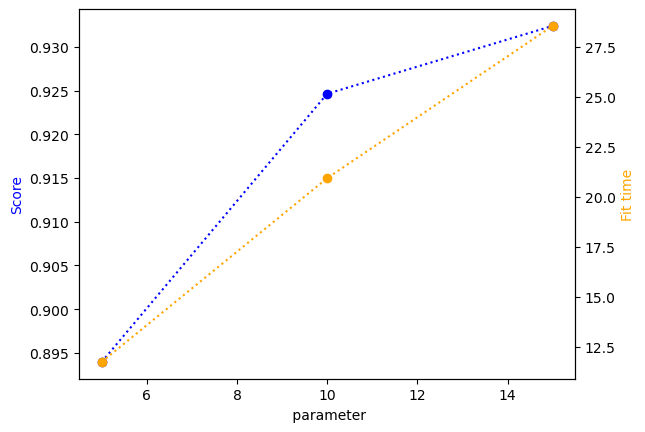

In [11]:
""" plot the results of the grid search against the hyperparameter values """
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(rf_param_max_depth, rf_mean_scores,'o:', color='blue', label="Mean Score")
ax2.plot(rf_param_max_depth, rf_mean_fit_times,'o:', color='orange', label="Mean Fit Time")
ax1.set_xlabel(' parameter')
ax1.set_ylabel('Score', color='blue')
ax2.set_ylabel('Fit time', color='orange')

plt.show()

In [ ]:
# Generate predictions for the test set
nn_predictions = nn_clf.predict(X_test)
svm_predictions = svm_clf.predict(X_test)
rf_predictions = rf_clf.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

# Define a dictionary that maps model names to their hyperparameters
model_hyperparams = {
    'Vanilla Neural Network': nn_grid_search.best_params_,
    'SVM': svm_grid_search.best_params_,
    'Random Forest': rf_grid_search.best_params_
}

# Compute the confusion matrix for each model
nn_confusion_matrix = metrics.confusion_matrix(y_test, nn_predictions)
svm_confusion_matrix = metrics.confusion_matrix(y_test, svm_predictions)
rf_confusion_matrix = metrics.confusion_matrix(y_test, rf_predictions)

# Print the confusion matrix and hyperparameters for each model
print('Vanilla Neural Network confusion matrix:')
print(nn_confusion_matrix)
print('Vanilla Neural Network hyperparameters:', model_hyperparams['Vanilla Neural Network'])

print('SVM confusion matrix:')
print(svm_confusion_matrix)
print('SVM hyperparameters:', model_hyperparams['SVM'])

print('Random Forest confusion matrix:')
print(rf_confusion_matrix)
print('Random Forest hyperparameters:', model_hyperparams['Random Forest'])

In [ ]:
# Evaluate the performance of each classifier
nn_accuracy = metrics.accuracy_score(y_test, nn_predictions)
svm_accuracy = metrics.accuracy_score(y_test, svm_predictions)
rf_accuracy = metrics.accuracy_score(y_test, rf_predictions)
print("Vanilla Neural Network Accuracy:", nn_accuracy)
print("SVM Accuracy:", svm_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

In [ ]:
from joblib import dump, load

In [ ]:
dump(nn_clf, 'nn_clf.joblib')

In [ ]:
dump(nn_grid_search, 'nn_grid_search.joblib')

In [ ]:
dump(svm_clf, 'svm_clf.joblib')

In [ ]:
dump(svm_grid_search, 'svm_grid_search.joblib')

In [ ]:
dump(rf_clf, 'rf_clf.joblib')

In [ ]:
dump(rf_grid_search, 'rf_grid_search.joblib')

In [ ]:
nn_clf = load('nn_clf.joblib')

In [ ]:
svm_clf = load('svm_clf.joblib')

In [ ]:
rf_clf = load('rf_clf.joblib')